# POS tagging using Modified Viterbi

- You have learnt to build your own HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. 
<br><br>
- The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. 
<br><br>
- This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

### Goal

- #### To modify the vanilla viterbi algorithm to adapt to the presence of unknown words and assign proper/ near accurate tags

#### Head over to this section where I started testing on sample sentences if the models are taking too much time

* [Testing on sample test sentences](#jump_in_case)
<br><br>
- The upper sections does take atleast a hour to run (Just in case)
<br><br>
- The sample file is being read from python notebook. In case of testing on a new file, change the file accordingly

### Data Preparation

In [1]:
#Importing libraries

import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
nltk_data[:1]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')]]

In [4]:
# Splitting into train and test
random.seed(42)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print("Training Set Length :", len(train_set))
print("Training Set Length :", len(test_set))
print("==" * 50)
print("Training Data sample :\n")
print(train_set[:10])

Training Set Length : 3718
Training Set Length : 196
Training Data sample :

[[('``', '.'), ('We', 'PRON'), ('have', 'VERB'), ('no', 'DET'), ('useful', 'ADJ'), ('information', 'NOUN'), ('on', 'ADP'), ('whether', 'ADP'), ('users', 'NOUN'), ('are', 'VERB'), ('at', 'ADP'), ('risk', 'NOUN'), (',', '.'), ("''", '.'), ('said', 'VERB'), ('*T*-1', 'X'), ('James', 'NOUN'), ('A.', 'NOUN'), ('Talcott', 'NOUN'), ('of', 'ADP'), ('Boston', 'NOUN'), ("'s", 'PRT'), ('Dana-Farber', 'NOUN'), ('Cancer', 'NOUN'), ('Institute', 'NOUN'), ('.', '.')], [('USX', 'NOUN'), ('has', 'VERB'), ('15', 'NUM'), ('working', 'NOUN'), ('days', 'NOUN'), ('0', 'X'), ('*', 'X'), ('to', 'PRT'), ('contest', 'VERB'), ('the', 'DET'), ('citations', 'NOUN'), ('and', 'CONJ'), ('proposed', 'VERB'), ('penalties', 'NOUN'), (',', '.'), ('before', 'ADP'), ('the', 'DET'), ('independent', 'ADJ'), ('Occupational', 'NOUN'), ('Safety', 'NOUN'), ('and', 'CONJ'), ('Health', 'NOUN'), ('Review', 'NOUN'), ('Commission', 'NOUN'), ('*T*-1', 'X'), (

In [5]:
# Get list of tagged tuples

train_tagged_tup = [tup for sent in train_set for tup in sent]
print(f" Num of tuples : {len(train_tagged_tup)}")
train_tagged_tup[:10]

 Num of tuples : 95623


[('``', '.'),
 ('We', 'PRON'),
 ('have', 'VERB'),
 ('no', 'DET'),
 ('useful', 'ADJ'),
 ('information', 'NOUN'),
 ('on', 'ADP'),
 ('whether', 'ADP'),
 ('users', 'NOUN'),
 ('are', 'VERB')]

In [6]:
# Get a list of tagged words

train_tagged_words = [pair[0] for pair in train_tagged_tup]
train_tagged_words[:10]

['``',
 'We',
 'have',
 'no',
 'useful',
 'information',
 'on',
 'whether',
 'users',
 'are']

In [7]:
# Get a list of tags 

train_tagged_tags = [pair[1] for pair in train_tagged_tup]
train_tagged_tags[:10]

['.', 'PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'ADP', 'NOUN', 'VERB']

In [8]:
## Building the vocabulary and the POS tag sets (haivng unique occurences)

train_vocab = set(train_tagged_words)
train_tags = set(train_tagged_tags)

print(f"Vocabulary_length : {len(train_vocab)} \nTagset_length : {len(train_tags)}")
print("\n")
print(f"Available tags : {train_tags}")

Vocabulary_length : 12066 
Tagset_length : 12


Available tags : {'VERB', 'ADJ', 'ADV', 'ADP', 'CONJ', 'PRON', '.', 'X', 'NOUN', 'PRT', 'NUM', 'DET'}


### Emission and Transition probabilities

In [9]:
len_tags = len(train_tags)
len_vocab = len(train_vocab)

word_given_tag = np.zeros((len_tags, len_vocab))

In [10]:
## computing emission probability (Word given tag = P(word | tag))

def word_given_tag(word, tag, train_bag = train_tagged_tup):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [11]:
# computing Transition Probability (tag2(t2) given tag1 (t1) = P(tag2 | tag1))

def t2_given_t1(t2, t1, train_bag = train_tagged_tup):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
tag_toTag_matrix = np.zeros((len_tags, len_tags), dtype='float32')
for i, t1 in enumerate(list(train_tags)):
    for j, t2 in enumerate(list(train_tags)): 
        tag_toTag_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tag_toTag_matrix

array([[1.69494152e-01, 6.49934188e-02, 8.18808600e-02, 9.14090946e-02,
        5.50003862e-03, 3.60213816e-02, 3.53241935e-02, 2.18452245e-01,
        1.09923311e-01, 3.03664114e-02, 2.23874822e-02, 1.34247422e-01],
       [1.17123062e-02, 6.53249770e-02, 4.78389952e-03, 7.65423924e-02,
        1.71560533e-02, 6.59848214e-04, 6.54899403e-02, 2.09501814e-02,
        7.00263917e-01, 1.10524576e-02, 2.11151429e-02, 4.94886190e-03],
       [3.42743278e-01, 1.31849885e-01, 7.87113905e-02, 1.18897378e-01,
        6.97442703e-03, 1.56094320e-02, 1.35835275e-01, 2.39123218e-02,
        3.15509811e-02, 1.39488541e-02, 3.08867488e-02, 6.90800399e-02],
       [8.20895564e-03, 1.06289975e-01, 1.35394456e-02, 1.74840093e-02,
        8.52878438e-04, 6.92963749e-02, 3.94456275e-02, 3.52878459e-02,
        3.23454171e-01, 1.49253733e-03, 6.11940287e-02, 3.23454171e-01],
       [1.59217879e-01, 1.17783986e-01, 5.49348220e-02, 5.21415286e-02,
        4.65549354e-04, 5.95903173e-02, 3.49161997e-02, 7.91

In [13]:
tags_df = pd.DataFrame(tag_toTag_matrix, columns = list(train_tags),index = list(train_tags))

tags_df

,VERB,ADJ,ADV,ADP,CONJ,PRON,.,X,NOUN,PRT,NUM,DET
VERB,0.169494,0.064993,0.081881,0.091409,0.005500,0.036021,0.035324,0.218452,0.109923,0.030366,0.022387,0.134247
ADJ,0.011712,0.065325,0.004784,0.076542,0.017156,0.000660,0.065490,0.020950,0.700264,0.011052,0.021115,0.004949
ADV,0.342743,0.131850,0.078711,0.118897,0.006974,0.015609,0.135835,0.023912,0.031551,0.013949,0.030887,0.069080
ADP,0.008209,0.106290,0.013539,0.017484,0.000853,0.069296,0.039446,0.035288,0.323454,0.001493,0.061194,0.323454
CONJ,0.159218,0.117784,0.054935,0.052142,0.000466,0.059590,0.034916,0.007914,0.348696,0.004190,0.041434,0.118715
PRON,0.488541,0.072956,0.033613,0.022918,0.004966,0.008021,0.038961,0.092437,0.207792,0.012605,0.007639,0.009549
.,0.088767,0.044159,0.052253,0.091645,0.057829,0.066643,0.093354,0.026981,0.222232,0.002338,0.081572,0.172138
X,0.203936,0.016823,0.025869,0.146009,0.010316,0.055388,0.162673,0.074115,0.061260,0.185685,0.002857,0.055071
NOUN,0.146456,0.011959,0.017026,0.176936,0.042694,0.004594,0.240047,0.029021,0.264657,0.043933,0.009406,0.013271
PRT,0.405255,0.083087,0.010181,0.021018,0.001970,0.017077,0.042693,0.012808,0.249589,0.001970,0.053202,0.101149


### Exploring the Data

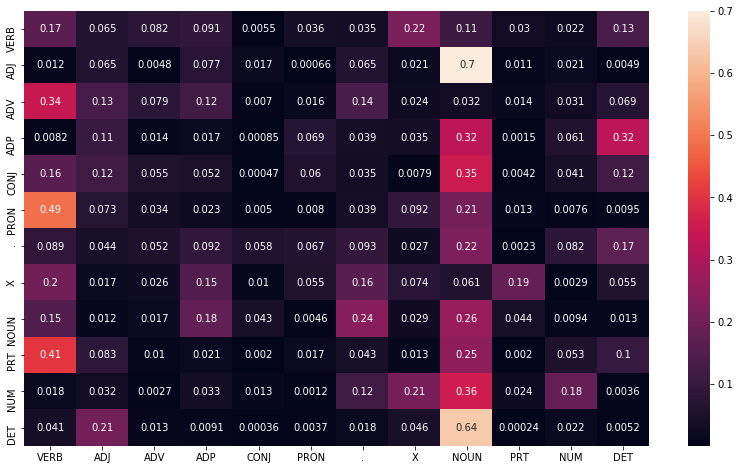

In [14]:
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

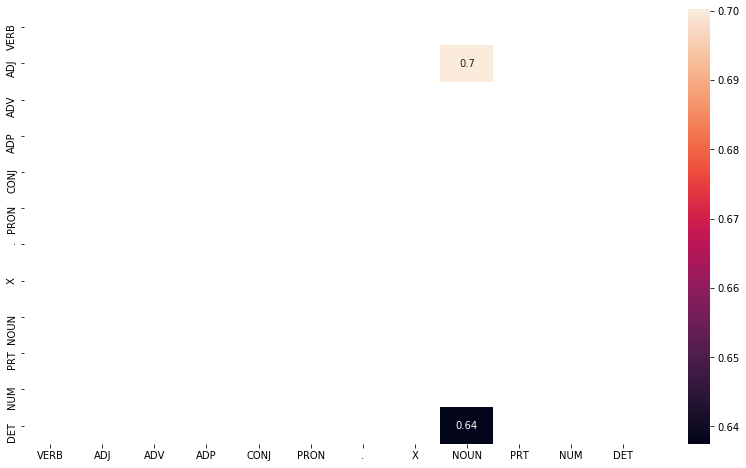

In [15]:
### To see the behaviour of most frequent tags, let us set a threshold to the P(tag2 | tag1) as 0.5

tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

#### Observation
- This shows that NOUN is the most frequent tag
- Also that is the same case whether it is being followed by an ADJ or by a DET

### Build the vanilla Viterbi based POS tagger

In [16]:
def vanilla_viterbi(words, train_bag = train_tagged_tup):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                trans_p = tags_df.loc['.', tag]
            else:
                trans_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emis_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emis_p * trans_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [17]:
random.seed(42)

# list of tagged tuples
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged tuples (Without tags)
test_untagged_words = [tup[0] for sent in test_set for tup in sent]


#### Tagging the words from test data

In [18]:
tagged_sequences = vanilla_viterbi(test_untagged_words)

In [21]:
## checing the accuracy of the vanilla viterbi algorithm

matches = [i for i, j in zip(tagged_sequences, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(matches)/len(tagged_sequences)

print("The accuracy of the Vanilla Viterbi Algorithm is -", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is - 0.9121314070849


In [25]:
# Let's have a look at the incorrectly tagged cases

non_matches = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_sequences, test_run_base)) if j[0]!=j[1]]
print(f"Incorrect tagged words :{len(non_matches)}")
matches

Incorrect tagged words :444


[('While', 'ADP'),
 ('renewed', 'VERB'),
 ('optimism', 'NOUN'),
 ('about', 'ADP'),
 ('the', 'DET'),
 ('outlook', 'NOUN'),
 ('for', 'ADP'),
 ('takeover', 'NOUN'),
 ('activity', 'NOUN'),
 ('boosted', 'VERB'),
 ('several', 'ADJ'),
 ('so-called', 'ADJ'),
 ('deal', 'NOUN'),
 ('stocks', 'NOUN'),
 (',', '.'),
 ('traders', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('profit-taking', 'NOUN'),
 ('weighed', 'VERB'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('market', 'NOUN'),
 (',', '.'),
 ('with', 'ADP'),
 ('bearing', 'VERB'),
 ('the', 'DET'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('.', '.'),
 ('These', 'DET'),
 ('small', 'ADJ'),
 ('but', 'CONJ'),
 ('influential', 'ADJ'),
 ('floor', 'NOUN'),
 ('brokers', 'NOUN'),
 ('long', 'ADV'),
 ('have', 'VERB'),
 ('earned', 'VERB'),
 ('fat', 'ADJ'),
 ('returns', 'NOUN'),
 ('of', 'ADP'),
 ('30', 'NUM'),
 ('%', 'NOUN'),
 ('to', 'PRT'),
 ('40', 'NUM'),
 ('%', 'NOUN'),
 ('*U*', 'X'),
 ('a', 'DET'),
 ('year', 'NOUN'),
 ('on', 'ADP'),
 ('their', 'PRON'),
 ('capital', 'NOUN'),

### Solve the problem of unknown words

#### Let's take a look at how many unknowns we have

In [26]:
# Unknown words 

test_vocab = set([t for t in test_untagged_words])

unknown_words = list(test_vocab - train_vocab)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :",unknown_words)

Total Unknown words : 342


Unknown Words : ['discordant', 'theaters', 'Equity', 'Holland', 'corkscrews', 'sitting', '188.84', 'WTVJ', 'ingenuity', 'muster', 'drops', 'Environment', 'crookery', 'Oak', 'Beirut', 'resign', 'fiber-optic', '6,799', 'concedes', '14.54', 'indictment', 'staffs', 'picking', 'Fundamentalists', '14.28', 'fan', 'boy', 'stock-selection', 'mid-afternoon', 'departments', '456.64', 'premier', '118.6', '148.9', 'avid', '300,000', 'manpower', 'Hammacher', 'Paper', 'copied', 'Lurie', 'carrying', 'strictly', 'redistribute', '*RNR*-4', 'semesters', 'Sprint', 'TEXAS', 'preapproved', 'manipulate', 'lessening', 'overnight', 'pistols', 'housing-assistance', '153.3', 'visits', 'overlap', 'disaffiliation', '0.60', '77.56', 'Suisse', 'explosive', '*-101', '1.18', 'Educational', 'cool', 'unmarked', 'simultaneously', 'occupying', 'leash', 'dirty', 'Tokio', 'medallions', 'Carbide', 'enjoying', 'Ferro', 'sticker', 'Prior', '467', 'Baris', 'Composite', 'Cougar', 'Brace', 'likelihood'

In [27]:
# Modified Viterbi Heuristic

def viterbi_unknown_words(words, train_bag = train_tagged_tup):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                trans_p = tags_df.loc['.', tag]
            else:
                trans_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emis_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in train_vocab:
                state_p = trans_p
            else:
                state_p = emis_p * trans_p
                
            p.append(state_p)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [28]:
# tagging the test sentences
unknowns_tagged_seq = viterbi_unknown_words(test_untagged_words)

In [29]:
# accuracy
unknowns_word_matches = [i for i, j in zip(unknowns_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknowns_word_matches)/len(unknowns_tagged_seq)

print("Accuracy of Viterbi Algorithm after modification :", optimized_viterbi_accuracy)

Accuracy of Viterbi Algorithm after modification : 0.9370670888581041


#### The modified version of viterbi performs better.
- The modification is : considering the transmission probabilities when the emission probability turns out "0" i.e., when the algotrithm encounters an unknown word

- The loss is still 6% and there is hope yet !!
- Let's try lexicon-based and rule-based methods and see if we can reduce the loss further

### Unigram tagger

In [30]:
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", unigram_accuracy)

The accuracy of the Unigram Tagger is - 0.8953097169998021


In [31]:
## Trying regexp tagging (rule-based)

# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [32]:
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger :", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger : 0.9297447061151791


### Bigram Tagger

In [33]:
bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)

#Accuracy of bigram tagger backed up by the rule based unigram tagger we used above

bigram_accuracy = bigram_tagger.evaluate(test_set)

print(f"Accuracy of Bigram Tagger backed up by Unigram RegexpTagger : {bigram_accuracy}")

Accuracy of Bigram Tagger backed up by Unigram RegexpTagger : 0.9327132396596082


### Trigram Tagger

In [34]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)

#Accuracy of bigram tagger backed up by the rule based unigram tagger we used above

trigram_accuracy = trigram_tagger.evaluate(test_set)

print(f"Accuracy of Trigram Tagger backed up by Bigram RegexpTagger : {trigram_accuracy}")

Accuracy of Trigram Tagger backed up by Bigram RegexpTagger : 0.9327132396596082


## Modification technique 2

#### As the trigram tagger is performing well on the tagging, we can use the trigram tagger to modify the viterbi when encountering the unknown words

- We have used the transmission probabiilities to replace "0"s in case of modification earlier.
- We will use the trigram tagger in its place

In [35]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [36]:
def viterbi_trigram_tagger(words, train_bag = train_tagged_tup):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in train_vocab:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    trans_p = tags_df.loc['.', tag]
                else:
                    trans_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emis_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_p = emis_p * trans_p    
                p.append(state_p)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [37]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_trigram_tagger(test_untagged_words)

In [38]:
# calculating accuracy
viterbi_trigram_matches = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_matches)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9534929744706115


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm <a class="anchor" id="jump_in_case"></a>

In [39]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_accuracy*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', bigram_accuracy*100],
                  ['Trigram Tagger + Bigram_tagger', trigram_accuracy*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,91.213141
Optimized Vanilla Viterbi,93.706709
Unigram Tagger,89.530972
Unigram + RegexpTagger,92.974471
Bigram Tagger + Unigram_tagger,93.271324
Trigram Tagger + Bigram_tagger,93.271324
Viterbi + Trigram_tagger,95.349297


#### Now that we've built and compared accuracies of different versions/ models, let's check how the algorithms are performing on the sample test sentences

In [2]:
sample_test_sentences = []

file = open("Sample_test_sentences.txt", "r")

for line in file:
    sample_test_sentences.append(line.strip())
    
file.close()

sample_test_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [41]:
sample_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_corpus_tags = nltk.pos_tag_sents(sample_tokenized_sents, tagset = 'universal')
sample_corpus_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [42]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_corpus_tags for tup in sent]


# list of tagged words
sample_test_run_base = [tup for sent in sample_corpus_tags for tup in sent]

In [43]:
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

### 1. Testing the accuracy of Vanilla Viterbi on sample test data - 

In [44]:
# tagging the test sentences
sample_test_tagged_seq = vanilla_viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7679558011049724


### 2. Testing the accuracy of Modified viterbi 1 on sample test data - 

In [46]:
# tagging the test sentences
sample_test_unknown_word_tagged_seq = viterbi_unknown_words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.8895027624309392


### 3. Testing the accuracy of Viterbi backed up by trigram tagger (Modified Viterbi 2) on sample test data - 

In [48]:
# tagging the test sentences
sample_test_viterbi_trigram_tagged_seq = viterbi_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is -", sample_test_viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 0.9281767955801105


### Comparing the accuracies of the vanilla viterbi and its modified versions on sample test sentences

In [49]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,76.795580
Optimized Viterbi,88.950276
Viterbi + Trigram_tagger,92.817680


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [50]:
# Default Vanilla Viterbi
# pos tags with Vanilla_Viterbi
sample_test_tagged_sequence_with_vanilla_viterbi = vanilla_viterbi(sample_test_tagged_words)

# Method 1 - pos tags with Vanilla_Viterbi_for_Unknown_Words
sample_test_tagged_sequence_unknown_words = viterbi_unknown_words(sample_test_tagged_words)


# Method 2 - pos tags with viterbi_backedup_by_trigram_tagger
sample_test_tagged_sequence_with_viterbi_trigram = viterbi_trigram_tagger(sample_test_tagged_words)

In [52]:
# A dataframe showing - 
# 1. the actual tags using nltk.pos_tag_sent
# 2. words as tagged by vanilla viterbi
# 3. words as tagged by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
# 4. words as tagged by viterbi_backedup_by_trigram_tagger - METHOD - 2

cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

# Actual tags
tags_comparison_df.actual_tags = [tup for tup in sample_test_run_base]

# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_tagged_sequence_unknown_words]

# tags by viterbi_backedup_by_trigram_tagger - METHOD - 2
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_tagged_sequence_with_viterbi_trigram]

### The below line of code will show where the modifications in viterbi helped correct the POS tags 

In [53]:
### All the instances where the viterbi_trigram tags are same as actual tags but not same as vanilla viterbi

tags_comparison_df[(tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger) & (tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger == tags_comparison_df.actual_tags)]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, VERB)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, VERB)","(Google, NOUN)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, VERB)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, VERB)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, VERB)","(worldwide, NOUN)","(worldwide, NOUN)"
20,"(2011, NUM)","(2011, VERB)","(2011, NOUN)","(2011, NUM)"
25,"(2013, NUM)","(2013, VERB)","(2013, NOUN)","(2013, NUM)"
27,"(Google, NOUN)","(Google, VERB)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, VERB)","(Twitter, NOUN)","(Twitter, NOUN)"
34,"(2015, NUM)","(2015, VERB)","(2015, NOUN)","(2015, NUM)"


## Conclusions

#### The POS tags assigned by the vanilla viterbi has many errors where as the ones assigned by the modifications were better
- Of the two modifications I have tried to make, the viterbi modification backed by trigram tagger which in turn is backed by the regexp tagger performed the best.

#### Modified methods :

#### Optimized Viterbi :

- We used the transition probabilities to replace the zeros obtained because of the presence of unknown words
- This method showed an accuracy of 94.347576 on the test data
 
- When tested on the sample test sentences, it tagged the sentences accurately for (~)88 times out of 100

#### Viterbi backed by trigram tagger :

- We used the trigram tagger which is backed by a regexp tagger to replace the zeros obtained because of the presence of unknown words
- This method showed an accuracy of 95.880437 on the test data
 
- When tested on the sample test sentences, it tagged the sentences accurately for (~)92 times out of 100


## The latter modification turned out the best (Viterbi backed by Trigram tagger)